In [1]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA

from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np


os.chdir('../raw_data')


In [3]:
os.listdir()

['ALL_GNPS.json',
 'ALL_GNPS_15_12_2021_positive_annotated.pickle',
 'ALL_GNPS_15_12_2021_positive_annotated_classifications.txt',
 'all_ms2ds_embedding.pickle',
 'all_spec_embedding.pickle',
 'df_ALL_GNPS_15_12_2021_positive_annotated_embeddings_class.pickle',
 'df_classes_all_embeddings.pickle',
 'df_classes_max3_embeddings.pickle',
 'df_classes_max5_embeddings.pickle',
 'df_classes_unique_embeddings.pickle',
 'GNPS_15_12_2021_ms2ds_embeddings.pickle',
 'lightning_logs',
 'max3_mol2vec_embedding.pickle',
 'max3_ms2ds_embedding.pickle',
 'max3_spec_embedding.pickle',
 'max5_mol2vec_embedding.pickle',
 'max5_ms2ds_embedding.pickle',
 'max5_spec_embedding.pickle',
 'model_300dim.pkl',
 'mol2vec_embedding.pickle',
 'ms2ds_embeddings_unique_GNPS_15_12_2021.pickle',
 'ms2ds_model_GNPS_15_12_2021.hdf5',
 'ms2ds_pred_euc',
 'plot_validation.py',
 'spec2vec_embeddings_unique_GNPS_15_12_2021.pickle',
 'spec2vec_model_GNPS_15_12_2021.model',
 'spec2vec_model_GNPS_15_12_2021.model.syn1neg.npy',


#### Functions to load and or write to pickle files

In [2]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [77]:
# load df with all info
path = './df_classes_unique_embeddings.pickle'
df_all = Files(path).load_pickle()[:2000] #just a subset for scripting
df_all.shape

(2000, 8)

In [78]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.3, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
test_df, val_df = train_test_split(test_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [79]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])

train_loader , val_loader = get_dataloaders(train_dataset, val_dataset, batch_size=128, num_workers=6,
                                              drop_last=False)
test_loader = get_dataloaders(test_dataset,batch_size=128, num_workers=6,
                                              drop_last=False)

In [ ]:
#params
N = len(train_dataset)
latent_dims = 100
epochs = 100
#cca = CCA(latent_dims=latent_dims).fit((X, Y))

# define encoders
encoder_1 = architectures.Encoder(latent_dims=100, feature_size=v1_train.shape[1], layer_sizes=(128,))
                                     
encoder_2 = architectures.Encoder(latent_dims=100, feature_size=v2_train.shape[1], layer_sizes=(128,))

# define variant algorithmns
# 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        )

# 2. SDL
sdl = DCCA_SDL(latent_dims,
                N=N, encoders=[encoder_1, encoder_2],
                lam=1e-2, lr=1e-3)

# Define the trainer
trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1,
        callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/objective")])# early stopage to reduce overfitting

# train
trainer.fit(dcca, train_loader,val_loader)

#transform the views to get z projections


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 90.1 K
----------------------------------------
90.1 K    Trainable params
0         Non-trainable params
90.1 K    Total params
0.360     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

In [73]:
dcca_corr = dcca.score(train_loader)
dcca_corr

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [68]:
dcca_test_corr = dcca.score(test_loader)
dcca_test_corr

array([0.93910187, 0.90630785, 0.8945268 , 0.89281903, 0.85830308,
       0.84133569, 0.82010511, 0.77776138, 0.76263751, 0.71645609])

In [161]:
sdl_train_corr = sdl.score(train_loader)
sdl_train_corr[0:5]

array([0.82638609, 0.7842669 , 0.72307127, 0.69809542, 0.66365872])

In [162]:
sdl_test_corr = sdl.score(test_loader)
sdl_test_corr[0:5]

array([0.84406029, 0.78790545, 0.73411914, 0.69159715, 0.68054101])

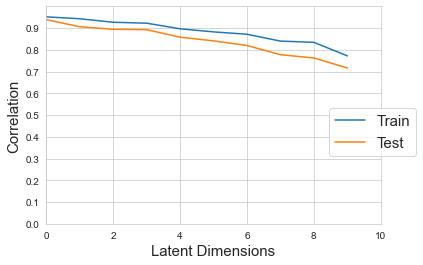

In [69]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()
sns.set_style('whitegrid')
dfs = [dcca_corr,dcca_test_corr]
for df in dfs:
    sns.lineplot(x=x,y=df,ax=ax)
fig.legend(labels=['Train', 'Test'], loc='center right', fontsize=15)
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1)
plt.xlim(0, latent_dims)
plt.yticks(np.arange(0, 1, step=0.1))
plt.show()

In [175]:
#score test dataset
# check the validation loop warning

In [78]:
v1_train.shape

(11200, 200)